# Лабораторна робота 4
## Побудова та оцінка класифікаційних моделей з використанням ансамблів
##### Виконала *Ваховська Віра Миколаївна*

##### Мета:
Вивчити методи побудови класифікаційних моделей, попередньої обробки даних,
використання ансамблевих методів та оцінки моделей.

##### 1. Вибір навчального набору даних
1. Оберіть навчальний набір даних для класифікатора на свій розсуд. Для цього можна скористатися платформою Kaggle (наприклад, Kaggle Datasets).
2. Завантажте та досліджуйте обраний набір даних.

##### 2. Попередня обробка даних
1. Виконайте очищення даних (обробка пропущених значень, видалення дублікатів тощо).
2. Виконайте нормалізацію або стандартизацію числових змінних (якщо необхідно).
3. Виконайте перетворення категоріальних змінних (наприклад, One-Hot Encoding).
4. Збалансуйте набір даних.
5. Розділіть набір даних на навчальну та тестову вибірки.

##### 3. Побудова класифікаційних моделей
1. Побудуйте декілька класифікаційних моделей, таких як:
- Логістична регресія
- Дерево рішень
- Підтримковий векторний класифікатор (SVC)
- K-найближчих сусідів (KNN)
- Наївний баєсів класифікатор
2. Навчіть моделі на навчальній вибірці та протестуйте на тестовій вибірці.

##### 4. Побудова ансамблів моделей
1. Побудуйте ансамбль моделей з використанням методів:
- Boosting (наприклад, AdaBoost, Gradient Boosting)
- Bagging (наприклад, Random Forest)
- Stacking (поєднання декількох базових моделей з використанням метамоделі)
2. Навчіть ансамблеві моделі на навчальній вибірці та протестуйте на тестовій вибірці.

##### 5. Оцінка моделей
3. Для кожного класифікатора та ансамблю побудуйте та оцініть:
- Матрицю невідповідностей (confusion matrix)
- Точність (accuracy)
- Прецизію (precision)
- Повторюваність (recall)
- F1-оцінку (F1-score)

##### 6. Побудова ROC кривих
1. Побудуйте ROC криві для всіх класифікаторів та їх ансамблів.
2. Оцініть краще з них за допомогою площі під кривою (AUC - Area Under Curve).

# Хід роботи

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# Моделі машинного навчання
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    ExtraTreesClassifier, 
    VotingClassifier,
    StackingClassifier
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Оцінка моделі та метрики
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve, 
    auc
)

# Модуль для валідації та налаштування моделей
from sklearn.model_selection import (
    GridSearchCV, 
    cross_val_score, 
    StratifiedKFold, 
    train_test_split, 
    learning_curve
)

### 1. Вибір навчального набору даних

In [2]:
# Завантаження даних
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")
IDtest = test["PassengerId"]

In [3]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


#### Про датасет

| Змінна     | Визначення                                 | Ключ                                                                                  |
|------------|--------------------------------------------|---------------------------------------------------------------------------------------|
| survival   | Статус виживання пасажира                 | 0 = Ні, 1 = Так                                                                       |
| pclass     | Клас квитка, показник соціально-економічного статусу (SES) | 1 = 1-й (Вищий), 2 = 2-й (Середній), 3 = 3-й (Нижчий)                                 |
| sex        | Стать пасажира                            | Н/Д                                                                                   |
| age        | Вік пасажира у роках                      | Дробовий, якщо менше 1 року. Оцінений вік подається у вигляді xx.5                    |
| sibsp      | Кількість братів/сестер або подружжя на борту | Брат/сестра = брат, сестра, зведені брат чи сестра; Подружжя = чоловік, дружина (коханки та наречені не враховані) |
| parch      | Кількість батьків/дітей на борту          | Батьки = мати, батько; Діти = син, дочка, зведені син чи дочка (діти з нянею отримали `parch = 0`) |
| ticket     | Номер квитка                              | Н/Д                                                                                   |
| fare       | Вартість квитка                           | Н/Д                                                                                   |
| cabin      | Номер каюти                               | Н/Д                                                                                   |
| embarked   | Порт посадки                              | C = Шербур, Q = Квінстаун, S = Саутгемптон                                           |

##### Примітки

- **pclass**: вказує соціально-економічний статус:
  - 1 = вищий клас;
  - 2 = середній клас;
  - 3 = нижчий клас.

- **age**: представляє вік пасажира. Якщо вік менше 1 року, він вказується як дробовий. Оцінені віки подаються у вигляді `xx.5`.

- **sibsp**:
  - брат/сестра = брат, сестра, зведені брат чи сестра;
  - подружжя = чоловік, дружина (коханки та наречені не враховані).

- **parch**:
  - батьки = мати, батько;
  - діти = син, дочка, зведені син чи дочка;
  - діти, які подорожували лише з нянею, отримали значення `parch = 0`.


### 2. Попередня обробка даних

In [5]:
# Об'єднання train і test для однакової кількості ознак
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [6]:
# Заповнення порожніх значень NaN
dataset = dataset.fillna(np.nan)

# Перевірка пропущених значень
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Детальний огляд усіх ознак

In [10]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

##### Sex

In [11]:
# 0 - чоловік, 1 - жінка
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

##### Name

In [12]:
# Виділення Title з Name
dataset["Title"] = dataset["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)
print("Унікальні заголовки:")
print(dataset["Title"].value_counts())

Унікальні заголовки:
Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64


In [13]:
# Групування рідкісних префіксів в єдину категорію
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'the Countess']
dataset["Title"] = dataset["Title"].replace(rare_titles, 'Rare')
print("Заголовки після групування:")
print(dataset["Title"].value_counts())

Заголовки після групування:
Title
Mr        757
Miss      260
Mrs       197
Master     61
Rare       29
Ms          2
Mlle        2
Mme         1
Name: count, dtype: int64


In [14]:
# Зіставлення заголоків та цілих цисел
title_mapping = {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
dataset["Title"] = dataset["Title"].map(title_mapping)
print("Зіставлені заголовки:")
print(dataset["Title"].value_counts())

Зіставлені заголовки:
Title
2    757
1    462
0     61
3     29
Name: count, dtype: int64


In [15]:
# Показати кількість кожного титулу у вигляді таблиці
title_counts = dataset["Title"].value_counts().reset_index()
title_counts.columns = ["Title", "Count"]
print(title_counts)

   Title  Count
0      2    757
1      1    462
2      0     61
3      3     29


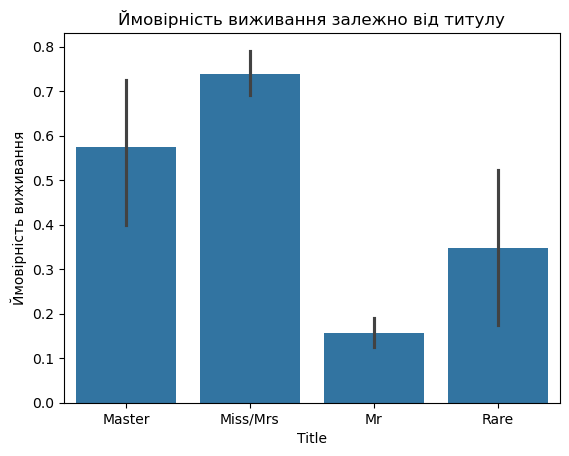

In [16]:
# Візуалізувати ймовірність виживання залежно від титулу
sns.barplot(x=dataset["Title"], y=dataset["Survived"])
plt.xticks([0, 1, 2, 3], ["Master", "Miss/Mrs", "Mr", "Rare"])
plt.ylabel("Ймовірність виживання")
plt.title("Ймовірність виживання залежно від титулу")
plt.show()

In [17]:
# Видалення та конвертування
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

##### Fare

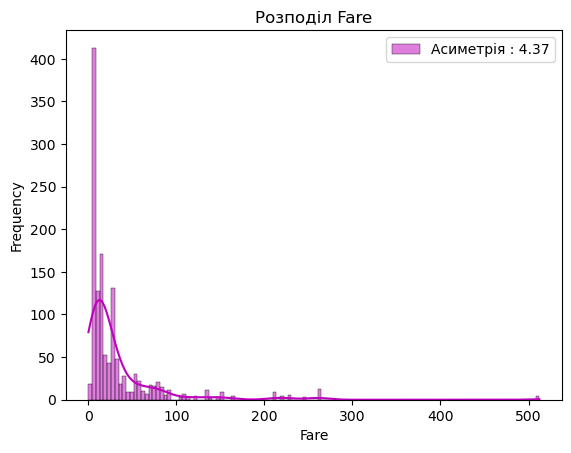

In [18]:
# Візуалізація розподілу Fare
g = sns.histplot(
    dataset["Fare"], 
    color="m", 
    kde=True,
    label="Асиметрія : %.2f" % (dataset["Fare"].skew())
)
plt.legend(loc="best")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.title("Розподіл Fare")
plt.show()

Розподіл Fare нерівномірний, тобто є сильний перекіс. Через це модель може надавати занадто велику вагу великим значенням, навіть після масштабування.  Я вирішила використати Log, щоб згладити розподіл.

In [19]:
# Логарифмічне перетворення Fare
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

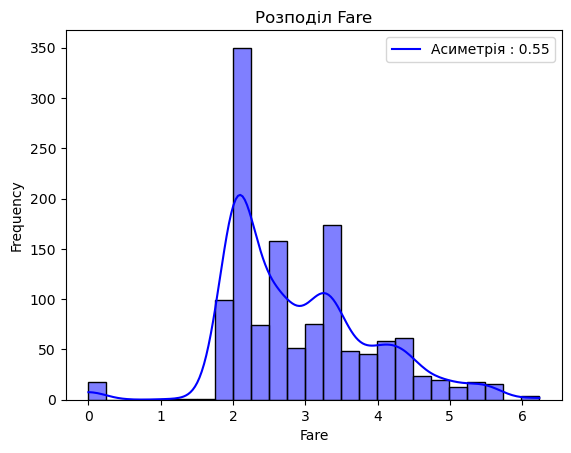

In [20]:
# Візуалізація розподілу Fare
g = sns.histplot(
    dataset["Fare"], 
    color="b", 
    kde=True,
)
plt.legend(["Асиметрія : %.2f" % (dataset["Fare"].skew())], loc="best")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.title("Розподіл Fare")
plt.show()

##### Age

Колонка Age містить багато пропущених значень. Оскільки вік може впливати на шанс виживання, краще зберегти цей показник і заповнити відсутні дані. Для вирішення проблеми я проаналізувала найбільш корельовані з віком ознаки.

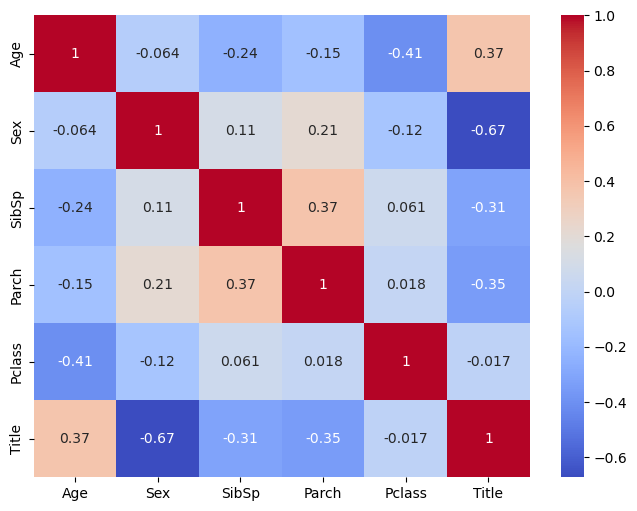

In [21]:
correlation_matrix = dataset[["Age", "Sex", "SibSp", "Parch", "Pclass", "Title"]].corr()
plt.figure(figsize=(8, 6))
g = sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True)
plt.show()

In [22]:
# Групування за Title і Pclass для розрахунку медіанного віку
median_ages = dataset.groupby(['Title', 'Pclass'])['Age'].median()

# Заповнення пропущених значень у колонці Age на основі медіан Title і Pclass
for i in dataset.index:
    if pd.isnull(dataset.loc[i, 'Age']):  # Перевірка, чи значення відсутнє
        title = dataset.loc[i, 'Title']
        pclass = dataset.loc[i, 'Pclass']
        
        # Якщо комбінація Title і Pclass існує, заповнити відповідним медіанним значенням
        if (title, pclass) in median_ages:
            dataset.loc[i, 'Age'] = median_ages[(title, pclass)]
        else:
            dataset.loc[i, 'Age'] = dataset['Age'].median()  # Якщо немає відповідності, використовувати загальну медіану

# Перевірка, чи залишилися пропущені значення у колонці Age
missing_age_count_after = dataset["Age"].isnull().sum()
print(f"Кількість пропущених значень Age після заповнення: {missing_age_count_after}")

Кількість пропущених значень Age після заповнення: 0


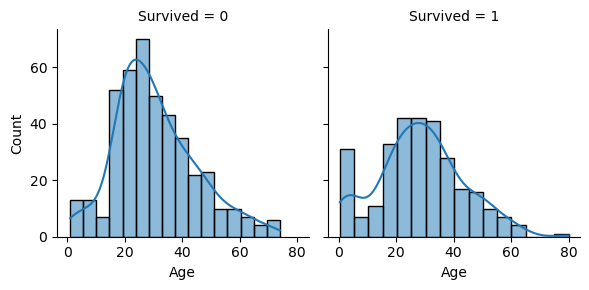

In [23]:
# Візуалізація розподілу віку з розбивкою за колонкою Survived
g = sns.FacetGrid(train, col='Survived')
g.map_dataframe(sns.histplot, x="Age", kde=True)
g.set_axis_labels("Age", "Count")
plt.show()

##### Embarked

Оскільки лише два відсутні значення, я вирішила заповнити їх найбільш частим значенням.

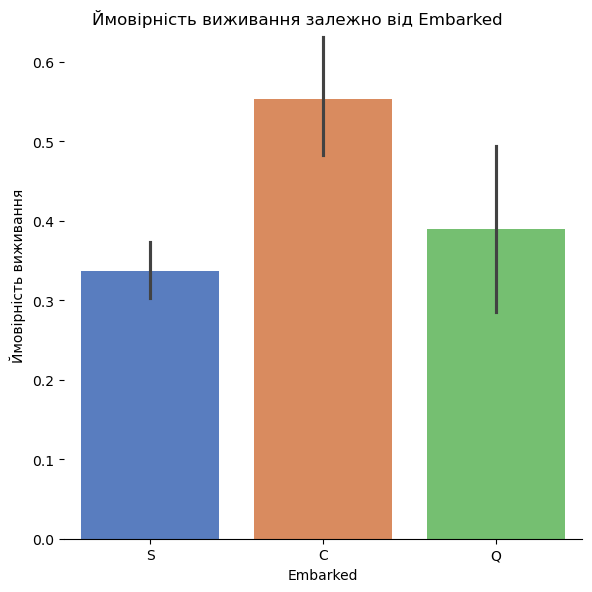

In [24]:
# Дослідження залежності між Embarked і Survived
g = sns.catplot(
    x="Embarked",
    y="Survived",
    hue="Embarked",
    data=train,
    kind="bar",
    height=6,
    palette="muted",
    legend=False
)

g.despine(left=True)
g.set_ylabels("Ймовірність виживання")
g.fig.suptitle("Ймовірність виживання залежно від Embarked")
plt.show()

In [25]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [26]:
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

##### Cabin

In [27]:
# Замінюємо відсутні значення в колонці 'Cabin' на 'X' та залишаємо лише тип каюти
dataset['Cabin'] = dataset['Cabin'].fillna('X')
dataset['Cabin'] = dataset['Cabin'].str[0]

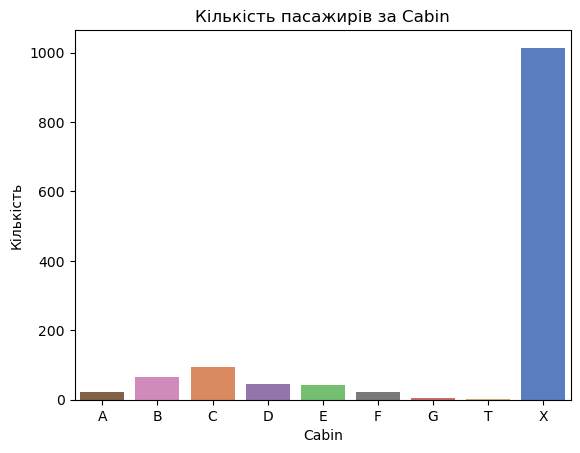

In [28]:
sns.countplot(
    data=dataset,
    x="Cabin",
    hue="Cabin",
    order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'],
    palette="muted"
)
plt.title("Кількість пасажирів за Cabin")
plt.ylabel("Кількість")
plt.xlabel("Cabin")
plt.show()

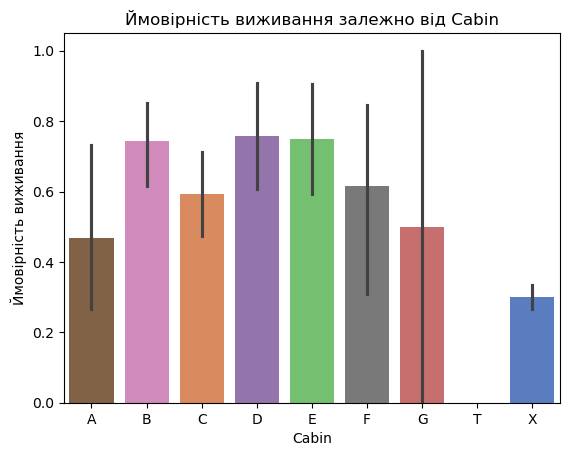

In [29]:
g = sns.barplot(
    x="Cabin",
    y="Survived",
    hue="Cabin",
    data=dataset,
    order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'],
    palette="muted"
)

g.set_title("Ймовірність виживання залежно від Cabin")
g.set_ylabel("Ймовірність виживання")
g.set_xlabel("Cabin")
plt.show()

Пасажири з каютами мали більше шансів на виживання, ніж ті, хто не мав (X).

In [30]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"], prefix="Cabin")

##### Ticket

In [31]:
# Виділення префікса квитка
Ticket = []
for i in list(dataset["Ticket"]):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0])  # Префікс
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [32]:
dataset = pd.get_dummies(dataset, columns=["Ticket"], prefix="T")

##### Pclass

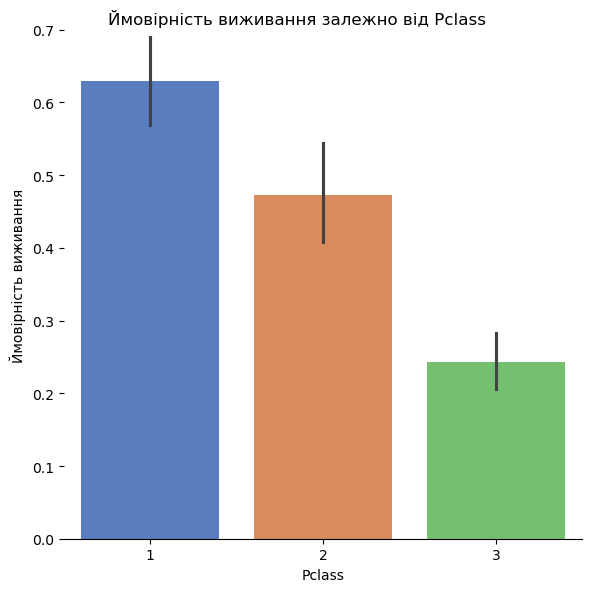

In [33]:
# Дослідження залежності між Pclass і Survived
g = sns.catplot(
    x="Pclass",
    y="Survived",
    hue="Pclass",
    data=train,
    kind="bar",
    height=6,
    palette="muted",
    legend=False
)

g.despine(left=True)
g.set_ylabels("Ймовірність виживання")
g.fig.suptitle("Ймовірність виживання залежно від Pclass")
plt.show()

In [34]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"], prefix="Pc")

##### SibSp

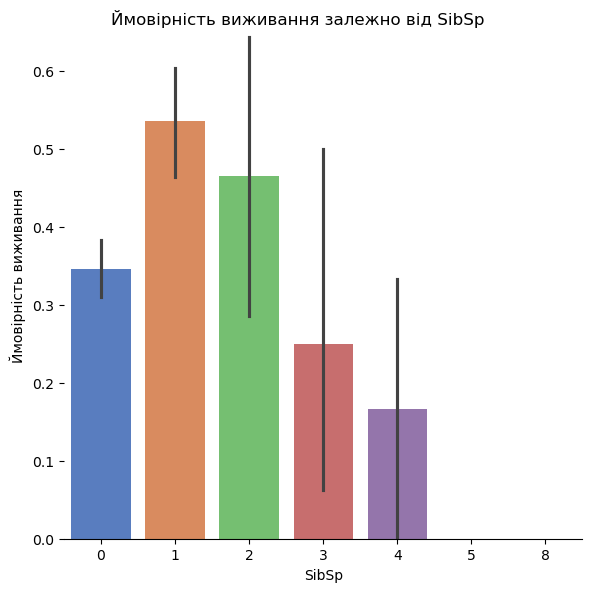

In [35]:
# Дослідження залежності між SibSp і Survived
g = sns.catplot(
    x="SibSp", 
    y="Survived", 
    hue="SibSp",  
    data=train, 
    kind="bar", 
    height=6, 
    palette="muted", 
    legend=False  
)

g.despine(left=True)
g.set_ylabels("Ймовірність виживання")
g.fig.suptitle("Ймовірність виживання залежно від SibSp")
plt.show()

##### Parch

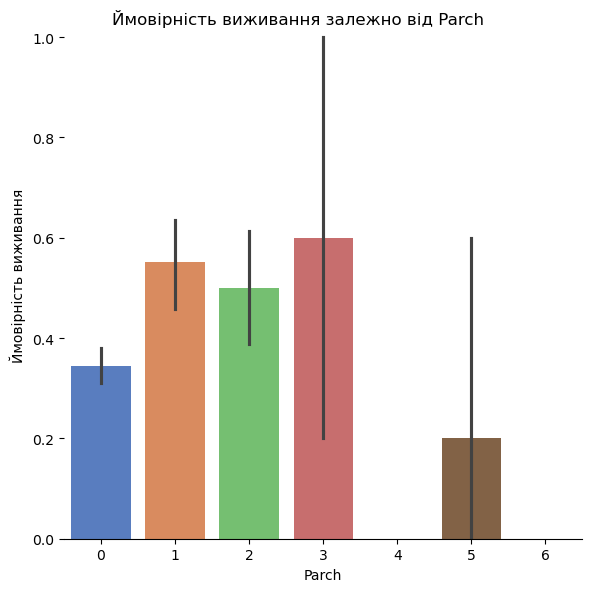

In [36]:
# Дослідження залежності між Parch і Survived
g = sns.catplot(
    x="Parch",
    y="Survived",
    hue="Parch",
    data=train,
    kind="bar",
    height=6,
    palette="muted",
    legend=False
)

g.despine(left=True)
g.set_ylabels("Ймовірність виживання")
g.fig.suptitle("Ймовірність виживання залежно від Parch")
plt.show()

##### PassengerId

In [37]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [38]:
dataset = pd.get_dummies(dataset, columns = ["Title"])

In [39]:
dataset = dataset.astype({col: int for col in dataset.select_dtypes('bool').columns})

In [40]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Em_C,Em_Q,Em_S,Cabin_A,...,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3,Title_0,Title_1,Title_2,Title_3
0,0.0,0,22.0,1,0,1.981001,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,1.0,1,38.0,1,0,4.266662,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
3,1.0,1,35.0,1,0,3.972177,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
4,0.0,0,35.0,0,0,2.085672,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0


### 3. Побудова класифікаційних моделей

In [41]:
# Розділяємо дані на тренувальні та тестові набори
train = dataset.iloc[:train_len].copy()  # Копія для тренувального набору
test = dataset.iloc[train_len:].copy()  # Копія для тестового набору

# Видаляємо колонку "Survived" із тестового набору (її немає у реальних тестових даних)
test = test.drop(labels=["Survived"], axis=1)

# Конвертуємо колонку "Survived" (int) у тренувальному наборі
train.loc[:, "Survived"] = train["Survived"].astype(int)

# Відокремлюємо ознаки та цільову змінну
Y_train = train["Survived"]  # Цільова змінна
X_train = train.drop(labels=["Survived"], axis=1)  # Ознаки

In [42]:
# Ініціалізація класифікаційних моделей
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Classifier": SVC(random_state=42, probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Функція для тренування та оцінки моделей
def train_and_evaluate_models(classifiers, X_train, Y_train, X_test, Y_test):
    results = []
    for name, model in classifiers.items():
        # Навчання моделі
        model.fit(X_train, Y_train)
        
        # Оцінка точності на тренувальній та тестовій вибірках
        train_accuracy = model.score(X_train, Y_train)
        test_accuracy = model.score(X_test, Y_test)
        
        # Додавання результатів до списку
        results.append({
            "Model": name,
            "Train Accuracy": round(train_accuracy, 4),
            "Test Accuracy": round(test_accuracy, 4)
        })
    return results

# Поділ на тренувальну і тестову вибірки
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

# Тренування моделей та отримання результатів
model_results = train_and_evaluate_models(classifiers, X_train, Y_train, X_test, Y_test)

# Перетворення результатів у DataFrame для зручного перегляду
results_df = pd.DataFrame(model_results)
print(results_df)

                       Model  Train Accuracy  Test Accuracy
0        Logistic Regression          0.8315         0.7989
1              Decision Tree          0.9930         0.8156
2  Support Vector Classifier          0.7346         0.6872
3        K-Nearest Neighbors          0.8567         0.7654
4                Naive Bayes          0.4677         0.4078


### 4. Побудова ансамблів моделей

In [43]:
# Крос-валідація з використанням StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

##### AdaBoost

In [44]:
DTC = DecisionTreeClassifier()

# Ініціалізація AdaBoost із зазначенням алгоритму SAMME
adaDTC = AdaBoostClassifier(estimator=DTC, random_state=7, algorithm="SAMME")

# Гіперпараметри для пошуку
ada_param_grid = {
    "estimator__criterion": ["gini", "entropy"],
    "estimator__splitter": ["best", "random"],
    "n_estimators": [1, 2],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]
}

# Ініціалізація GridSearchCV
gsadaDTC = GridSearchCV(
    adaDTC,
    param_grid=ada_param_grid,
    cv=kfold,
    scoring="accuracy",
    n_jobs=4,
    verbose=1
)

# Навчання моделі
gsadaDTC.fit(X_train, Y_train)

# Найкраща модель
ADA_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 56 candidates, totalling 560 fits


0.8048904538341157

##### RFC Parameters tunning 

In [45]:
RFC = RandomForestClassifier()

rf_param_grid = {
    "max_depth": [None],
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators": [100, 300],
    "criterion": ["gini"]
}

gsRFC = GridSearchCV(
    RFC,
    param_grid=rf_param_grid,
    cv=kfold,
    scoring="accuracy",
    n_jobs=4,
    verbose=1
)
gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8343505477308295

##### Extra Trees (Extremely Randomized Trees)

In [46]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {
    "max_depth": [None],
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [False],
    "n_estimators": [100, 300],
    "criterion": ["gini"]
}

gsExtC = GridSearchCV(
    estimator=ExtC,
    param_grid=ex_param_grid,
    cv=kfold,
    scoring="accuracy",
    n_jobs=4,
    verbose=1
)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8315336463223788

##### Gradient Boosting

In [47]:
GBC = GradientBoostingClassifier()

gb_param_grid = {
    "loss": ["log_loss"],
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [4, 8],
    "min_samples_leaf": [100, 150],
    "max_features": [0.3, 0.1]
}

gsGBC = GridSearchCV(
    estimator=GBC,
    param_grid=gb_param_grid,
    cv=kfold,
    scoring="accuracy",
    n_jobs=4,
    verbose=1
)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8273082942097026

##### SVC classifier

In [48]:
SVMC = SVC(probability=True)

svc_param_grid = {
    "kernel": ["rbf"],
    "gamma": [0.001, 0.01, 0.1, 1],
    "C": [1, 10, 50, 100, 200, 300, 1000]
}

gsSVMC = GridSearchCV(
    estimator=SVMC,
    param_grid=svc_param_grid,
    cv=kfold,
    scoring="accuracy",
    n_jobs=4,
    verbose=1
)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8315727699530516

In [49]:
# Базові моделі та фінальний класифікатор
base_estimators = [
    ('ada', ADA_best),
    ('rf', RFC_best),
    ('extc', ExtC_best),
    ('gbc', GBC_best),
    ('svc', SVMC_best)
]
final_estimator = LogisticRegression()

# Ініціалізація та навчання StackingClassifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=kfold,
    n_jobs=4
)
stacking_clf.fit(X_train, Y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=10,
        random_state=RandomState(MT19937) at 0x18BAD319A40, shuffle=False),
                   estimators=[('ada',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                    splitter='random'),
                                                   learning_rate=0.0001,
                                                   n_estimators=1,
                                                   random_state=7)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_features=3,
                                                       min_samples_leaf=3,
                                                       min_samples_split=3,
                                                       n_estimators=300)),
                               ('extc',
                                ExtraTreesClassifier(max_features=1,
                                                     min_samples_split=10)),
                               ('gbc',
                                GradientBoostingClassifier(max_depth=4,
                                                           max_features=0.3,
                                                           min_samples_leaf=100,
                                                           n_estimators=300)),
                               ('svc',
                                SVC(C=300, gamma=0.001, probability=True))],
                   final_estimator=LogisticRegression(), n_jobs=4)

In [50]:
# Оцінка на тренувальних і тестових вибірках
stacking_train_score = stacking_clf.score(X_train, Y_train)
stacking_test_score = stacking_clf.score(X_test, Y_test)

# Додавання результатів StackingClassifier
results = [{
    "Model": "Stacking",
    "Train Accuracy": round(stacking_train_score, 4),
    "Test Accuracy": round(stacking_test_score, 4)
}]

# Оцінка окремих моделей
models = {
    "AdaBoost": gsadaDTC.best_estimator_,
    "Random Forest": RFC_best,
    "Extra Trees": ExtC_best,
    "Gradient Boosting": GBC_best,
    "SVC": gsSVMC.best_estimator_
}

for name, model in models.items():
    train_accuracy = model.score(X_train, Y_train)
    test_accuracy = model.score(X_test, Y_test)
    results.append({
        "Model": name,
        "Train Accuracy": round(train_accuracy, 4),
        "Test Accuracy": round(test_accuracy, 4)
    })

# Створення та вивід таблиці результатів
results_df = pd.DataFrame(results)
print(results_df)

               Model  Train Accuracy  Test Accuracy
0           Stacking          0.9143         0.8268
1           AdaBoost          0.9930         0.7765
2      Random Forest          0.8736         0.7989
3        Extra Trees          0.9143         0.7877
4  Gradient Boosting          0.8666         0.7989
5                SVC          0.8525         0.8268


### 5. Оцінка моделей

In [51]:
def get_metrics_table(classifiers, X_test, Y_test):
    metrics = []
    for name, model in classifiers.items():
        Y_pred = model.predict(X_test)
        metrics.append({
            "Model": name,
            "Accuracy": accuracy_score(Y_test, Y_pred),
            "Precision": precision_score(Y_test, Y_pred, zero_division=0),
            "Recall": recall_score(Y_test, Y_pred),
            "F1-Score": f1_score(Y_test, Y_pred)
        })
    return pd.DataFrame(metrics).round(4)

In [52]:
def plot_confusion_matrices(classifiers, X_test, Y_test):
    for name, model in classifiers.items():
        Y_pred = model.predict(X_test)
        conf_matrix = confusion_matrix(Y_test, Y_pred)
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {name}")
        plt.show()

                        Model  Accuracy  Precision  Recall  F1-Score
0         Logistic Regression    0.7989     0.7538  0.7101    0.7313
1               Decision Tree    0.8156     0.7647  0.7536    0.7591
2   Support Vector Classifier    0.6872     0.7826  0.2609    0.3913
3         K-Nearest Neighbors    0.7654     0.7455  0.5942    0.6613
4                 Naive Bayes    0.4078     0.3892  0.9420    0.5508
5                    AdaBoost    0.7765     0.7164  0.6957    0.7059
6               Random Forest    0.7989     0.8235  0.6087    0.7000
7                 Extra Trees    0.7877     0.7541  0.6667    0.7077
8           Gradient Boosting    0.7989     0.7895  0.6522    0.7143
9                         SVC    0.8268     0.7969  0.7391    0.7669
10                   Stacking    0.8268     0.8167  0.7101    0.7597


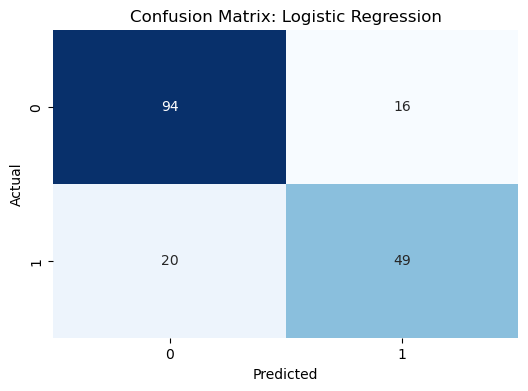

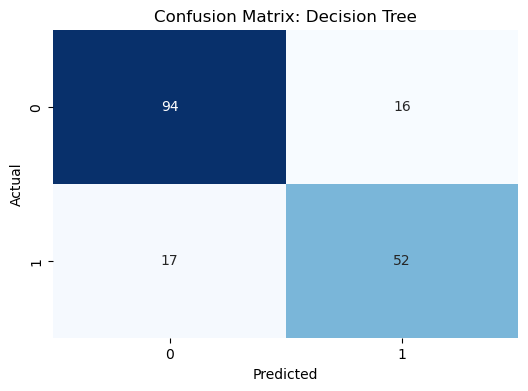

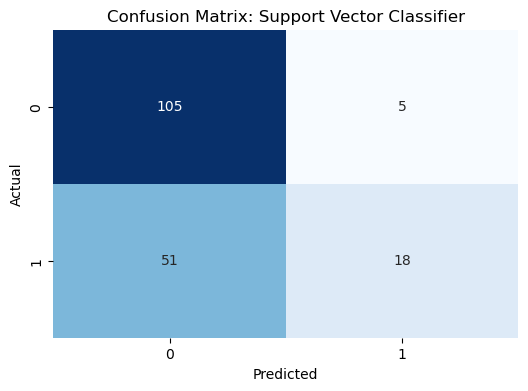

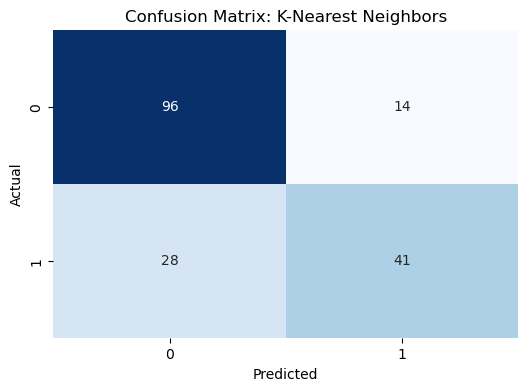

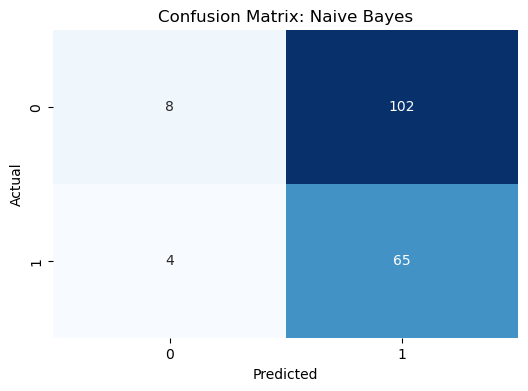

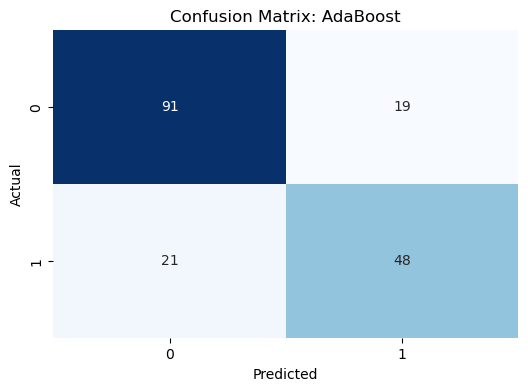

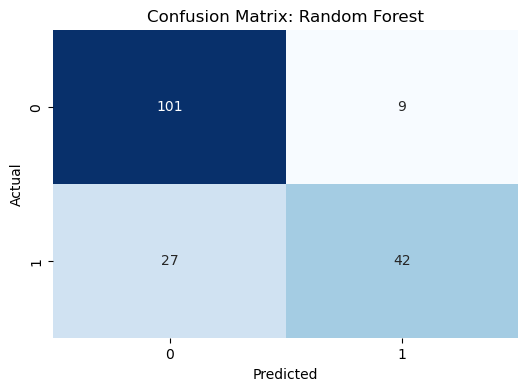

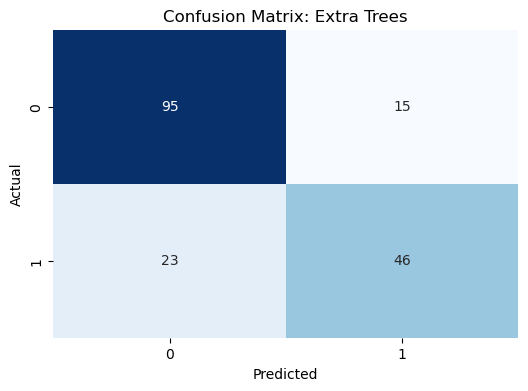

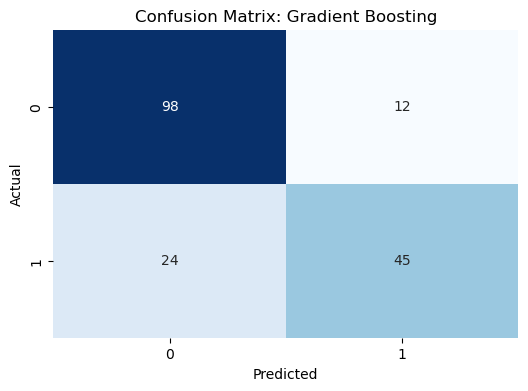

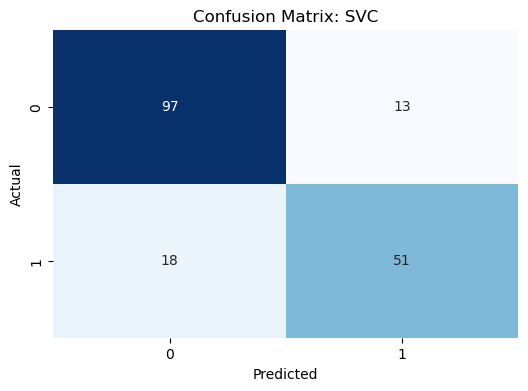

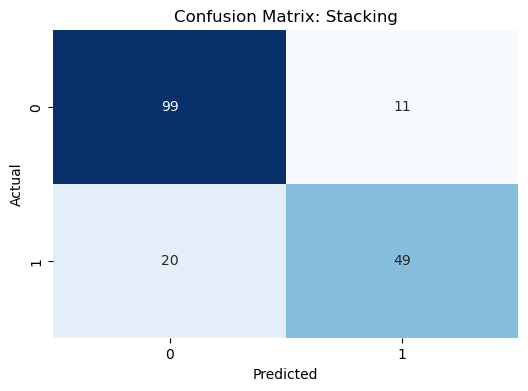

In [53]:
# Об'єднання ансамблів і класифікаторів
all_models = {**classifiers, **models}
all_models["Stacking"] = stacking_clf

# Вивід метрик
metrics_table = get_metrics_table(all_models, X_test, Y_test)
print(metrics_table)

# Візуалізація матриць невідповідностей
plot_confusion_matrices(all_models, X_test, Y_test)

### 6. Побудова ROC кривих

In [54]:
# Функція для побудови ROC кривих
def plot_roc_curves(classifiers, X_test, Y_test):
    plt.figure(figsize=(10, 8))
    for name, model in classifiers.items():
        Y_prob = get_prediction_probabilities(model, X_test)
        fpr, tpr, _ = roc_curve(Y_test, Y_prob)
        auc = roc_auc_score(Y_test, Y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-криві')
    plt.legend()
    plt.grid(True)
    plt.show()

In [55]:
# Функція для підрахунку AUC
def calculate_auc(classifiers, X_test, Y_test):
    auc_results = []
    for name, model in classifiers.items():
        Y_prob = get_prediction_probabilities(model, X_test)
        auc = roc_auc_score(Y_test, Y_prob)
        auc_results.append({"Model": name, "AUC": round(auc, 4)})
    
    auc_df = pd.DataFrame(auc_results)
    return auc_df.sort_values(by='AUC', ascending=False)

In [56]:
# Допоміжна функція для отримання ймовірностей або рішень
def get_prediction_probabilities(model, X_test):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X_test)[:, 1]
    else:
        return model.decision_function(X_test)

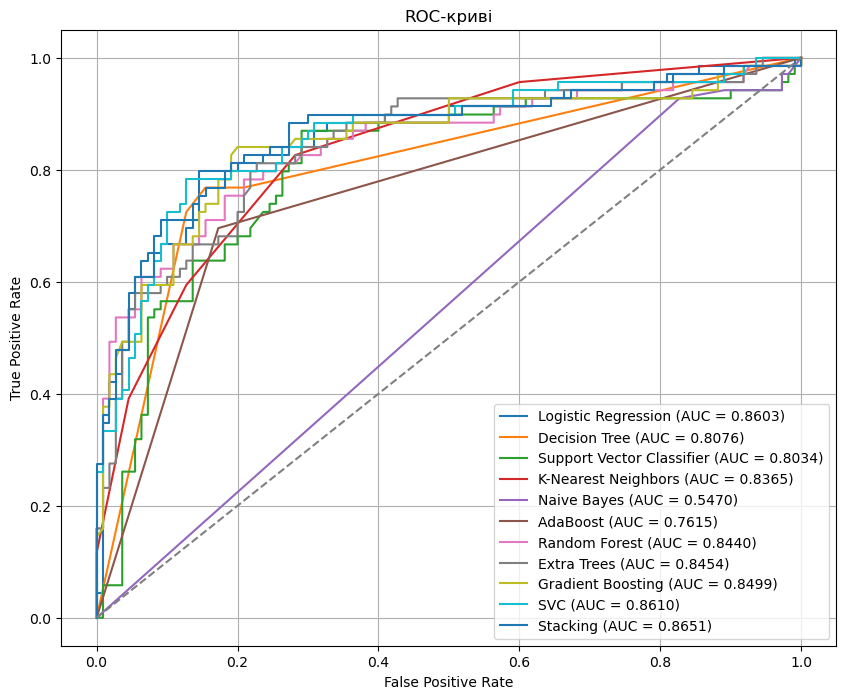

                        Model     AUC
10                   Stacking  0.8651
9                         SVC  0.8610
0         Logistic Regression  0.8603
8           Gradient Boosting  0.8499
7                 Extra Trees  0.8454
6               Random Forest  0.8440
3         K-Nearest Neighbors  0.8365
1               Decision Tree  0.8076
2   Support Vector Classifier  0.8034
5                    AdaBoost  0.7615
4                 Naive Bayes  0.5470


In [57]:
# Побудова кривих
plot_roc_curves(all_models, X_test, Y_test)

# Підрахунок AUC
auc_df = calculate_auc(all_models, X_test, Y_test)
print(auc_df)

### Додатково

#### Візуалізація найважливіших ознак

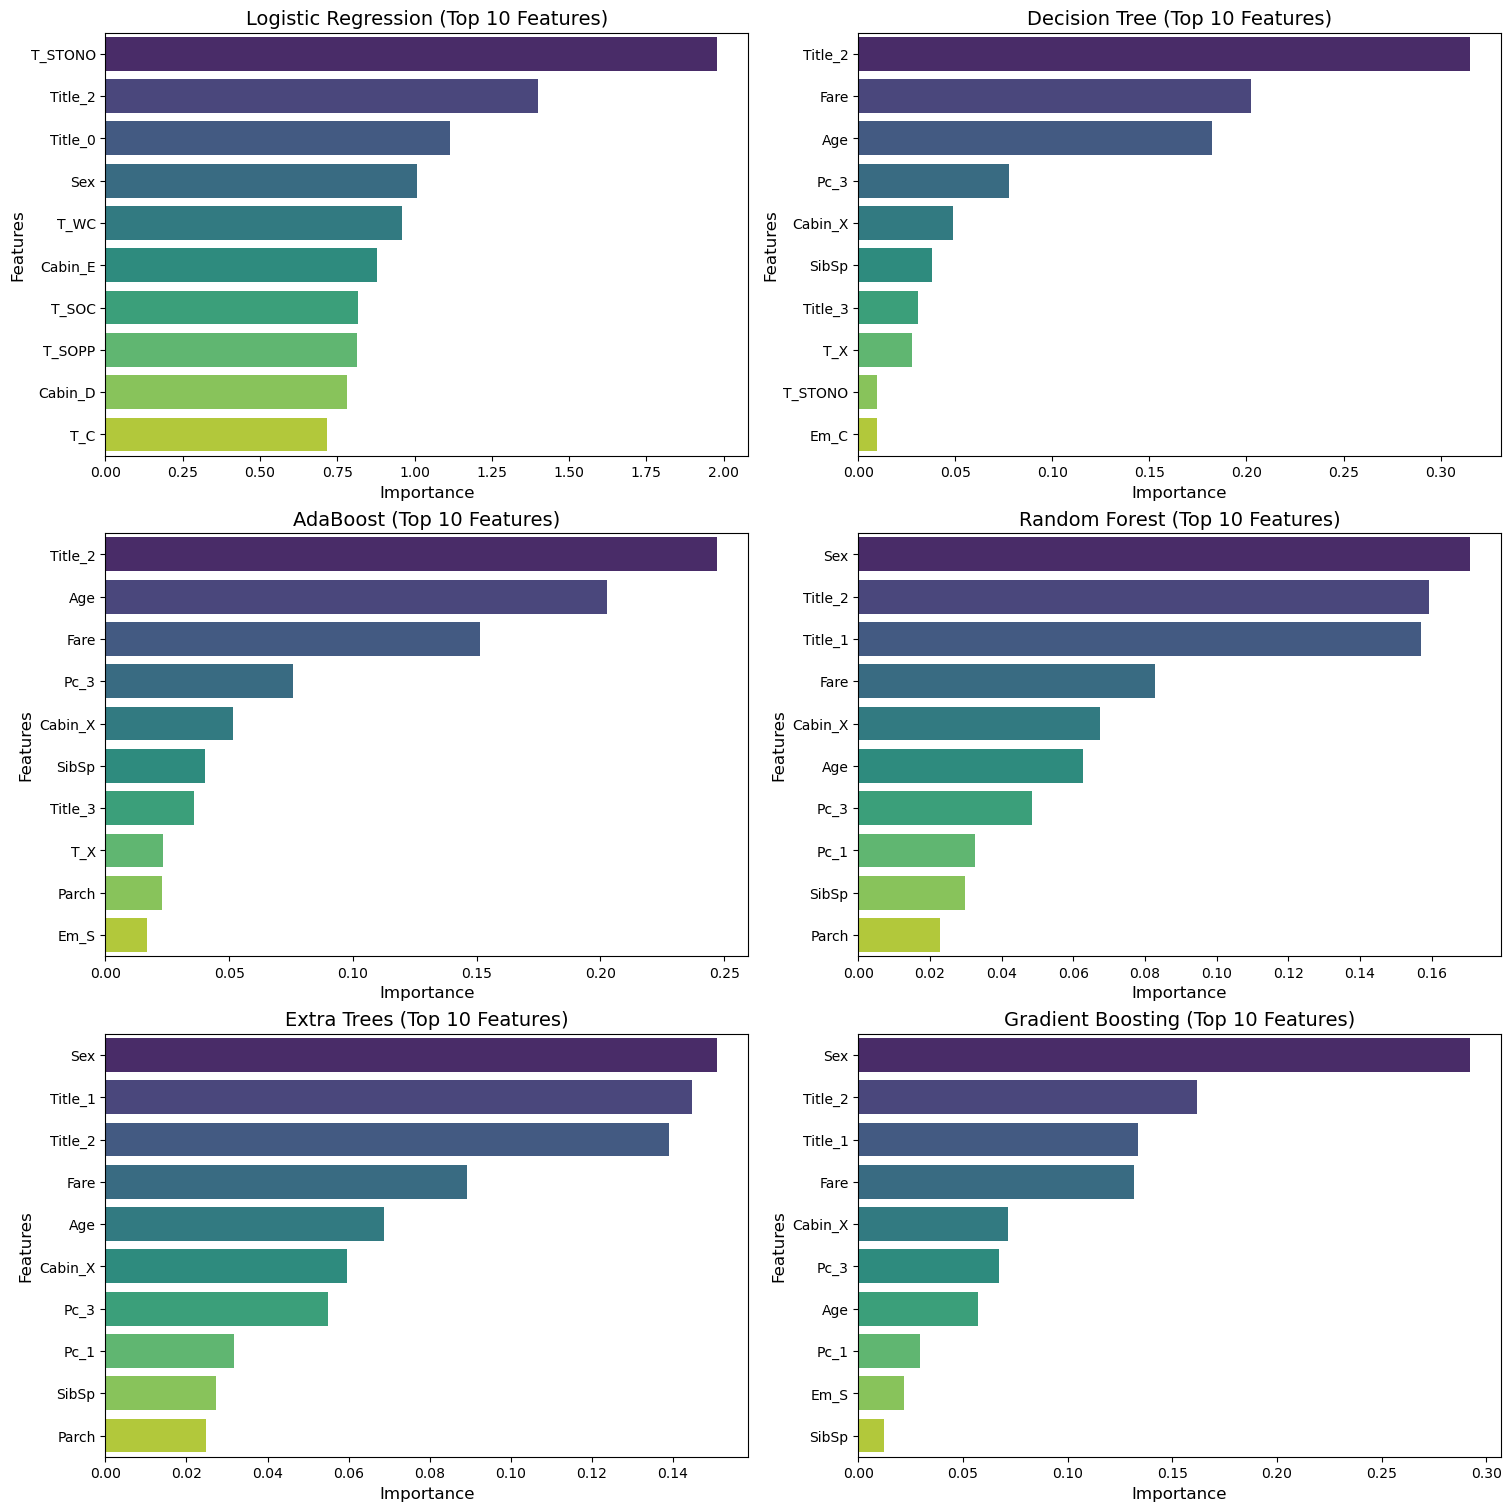

In [58]:
def plot_feature_importance(models, feature_names, top_n=10):
    # Вибір моделей, які підтримують важливість ознак
    valid_models = {
        name: model for name, model in models.items()
        if hasattr(model, 'feature_importances_') or hasattr(model, 'coef_')
    }
    
    ncols = 2
    nrows = (len(valid_models) + ncols - 1) // ncols  # Розрахунок кількості рядків
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), constrained_layout=True)

    axes = axes.flatten()  # Вирівнення по осі
    for idx, (name, model) in enumerate(valid_models.items()):
        # Отримуємо важливість ознак
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_).flatten()

        # Вибираємо топ-N найважливіших ознак
        sorted_idx = np.argsort(importances)[-top_n:][::-1]
        top_features = np.array(feature_names)[sorted_idx]
        top_importances = importances[sorted_idx]

        # Візуалізація
        sns.barplot(
            ax=axes[idx], 
            x=top_importances, 
            y=top_features, 
            hue=top_features, 
            palette="viridis", 
            orient="h", 
            dodge=False, 
            legend=False
        )
        axes[idx].set_title(f'{name} (Top {top_n} Features)', fontsize=14)
        axes[idx].set_xlabel('Importance', fontsize=12)
        axes[idx].set_ylabel('Features', fontsize=12)

    # Видаляємо пусті графіки, якщо моделей менше, ніж місць на сітці
    for idx in range(len(valid_models), len(axes)):
        fig.delaxes(axes[idx])

    plt.show()

# Виклик функції для всіх моделей
plot_feature_importance(all_models, X_train.columns, top_n=10)

#### Збереження результату

In [61]:
test_Survived = pd.Series(stacking_clf.predict(test).astype(int), name="Survived")

results = pd.concat([IDtest, test_Survived],axis=1)

results.to_csv("result.csv",index=False)

**Висновок:** було виконано обробку даних з набору Titanic для подальшого моделювання з метою прогнозування ймовірності виживання пасажирів. На першому етапі було проведено аналіз даних, виявлені пропущені значення та коригування на основі специфічних умов, таких як заповнення порожніх значень для колонки "Age" за допомогою медіан, обчислених на основі поєднання ознак "Title" та "Pclass". Колонку "Title" було отримано з "Name", а саме шляхом виділення заголовків (Title) використовуючи регулярні вирази. Унікальні заголовки, такі як "Mr", "Miss", "Mrs", "Master" тощо, були згруповані, а рідкісні заголовки об'єднані в єдину категорію "Rare". Для зручності моделювання ці заголовки були зіставлені з числовими значеннями (наприклад, "Master" – 0, "Miss/Mrs" – 1, "Mr" – 2, "Rare" – 3). Було здійснено перетворення та очищення колонок, таких як "Fare", "Embarked", "Cabin" та "Ticket", що дозволило знизити можливі спотворення, які могли б виникнути через нерівномірність розподілу чи відсутність значень.

Зокрема, для колонки "Fare" застосовано логарифмічне перетворення для зменшення перекосу у розподілі значень, що є важливим кроком для покращення якості моделювання. Оскільки колонки "Cabin" і "Ticket" містили багато пропущених або некоректних значень, було виконано їх коригування та перетворення на категоріальні змінні для подальшого використання в моделях. Дані були приведені до формату, що дозволяє їх безпосереднє використання для машинного навчання, включаючи перетворення категоріальних змінних на однозначні бінарні ознаки за допомогою кодування за допомогою one-hot encoding.

Додатково була візуалізована залежність ймовірності виживання від інших ознак.

було протестовано декілька класифікаторів, серед яких логістична регресія, дерева рішень, ансамблеві методи (Random Forest, Gradient Boosting, AdaBoost, Extra Trees), метод опорних векторів (SVC), алгоритм найближчих сусідів (KNN) та наївний баєсів класифікатор. Окрім того, було побудовано модель стекингу, яка поєднала результати інших класифікаторів для досягнення кращої продуктивності.

Оцінка моделей проводилася за основними метриками класифікації – точність (Accuracy), прецизійність (Precision), повнота (Recall) та F1-Score. Було створено матриці невідповідностей (Confusion Matrix) для кожної моделі, що дозволило проаналізувати типові помилки. Для глибшої оцінки було побудовано ROC-криві та обчислено площу під кривою (AUC), що є ключовою характеристикою для порівняння моделей.

Результати показали, що ансамблеві методи, зокрема Random Forest, Gradient Boosting та Extra Trees, демонструють стабільно високу продуктивність. Модель стекингу досягла найкращих показників як за F1-Score, так і за AUC, що свідчить про ефективність комбінування декількох класифікаторів. Support Vector Classifier (SVC) та логістична регресія також показали високий рівень продуктивності, зокрема в розрахунку AUC, що вказує на їхню ефективність при роботі з лінійно роздільними даними.

Окрім оцінки моделей, було виконано аналіз важливості ознак для моделей, які підтримують відповідну функціональність. 